## Evaluation metrics

This notebook is built based on our baseline model pytorch v3 version.

In [0]:
import os
import json
from collections import defaultdict
from tqdm import tqdm
import pickle
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from torchsummary import summary
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

from nltk.translate import bleu_score
import pandas as pd
START = "startseq"
STOP = "endseq"
EPOCHS = 10



### Google CoLab

If you are using Google CoLab then you will need to execute this cell.

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root_captioning = "/content/drive/My Drive/"
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


## 1. Load dataset

- Read captions
- Preprocess captions

> We need image paths, word lookup tables, and max_length in generating function

In [0]:
set_names = ['rsicd', 'ucm']

def get_img_info(name, num):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    num: int
        the number of observations to get

    Return:
    --------
    list, dict, int
        img paths, corresponding captions, max length of captions
    """
    img_path = []
    caption = [] 
    max_length = 0
    with open(f'{root_captioning}capstone/data/interim/{name}.json', 'r') as json_data:
        data = json.load(json_data)
        for set_name in set_names:
            for filename in data[set_name].keys():
                if len(caption) == num:
                    break

                img_path.append(
                    f'{root_captioning}mda/{set_name}/{filename}'
                    )
                sen_list = []
                for sentence in data[set_name][filename]['sentences']:
                    max_length = max(max_length, len(sentence['tokens']))
                    sen_list.append(sentence['raw'])

                caption.append(sen_list)
    
    return img_path, caption, max_length            


In [0]:
# get img path and caption list
# only test 800 train samples and 200 valid samples
train_paths, train_descriptions, max_length_train = get_img_info('train', 800)
test_paths, test_descriptions, max_length_test = get_img_info('valid', 200)
max_length = max(max_length_train, max_length_test)


In [5]:
print(len(train_descriptions)) # How many images? 
print(len(test_descriptions)) # How many images? 
print(max_length) # Maximum length of a caption (in words)

800
200
30


In [6]:
print(len(train_paths))
print(len(test_paths))

800
200


In [7]:
train_paths[0]

'/content/drive/My Drive/mda/rsicd/denseresidential_363.jpg'

In [0]:
# add start and stop token
for v in train_descriptions: 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [9]:
train_descriptions[0]

['startseq the area is a densely populated area . endseq',
 'startseq many green plants are planted around the neighborhood . endseq',
 'startseq many green plants are planted around the neighborhood . endseq',
 'startseq the area is a densely populated area . endseq',
 'startseq the area is a densely populated area . endseq']

In [10]:
# append all train captions
all_train_captions = []
for val in train_descriptions:
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

4000

In [11]:
all_train_captions[0]

'startseq the area is a densely populated area . endseq'

In [12]:
# remove words occur less than 10 times
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 1061 ==> 270


In [13]:
# build lookup tables
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

271

In [14]:
# adjust max_length
max_length +=2
print(max_length)

32


In [15]:

# load device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 2. Load functions (they are required for loading trained model)

In [0]:
class CNNModel(nn.Module):

    def __init__(self, cnn_type, pretrained=True):
        """
        Initializes a CNNModel

        Parameters:
        -----------
        cnn_type: str
            the CNN type, either 'vgg16' or 'inception_v3'
        pretrained: bool (default: True)
            use pretrained model if True

        """

        super(CNNModel, self).__init__()

        if cnn_type == 'vgg16':
          self.model = models.vgg16(pretrained=pretrained)

          # remove the last two layers in classifier
          self.model.classifier = nn.Sequential(
              *list(self.model.classifier.children())[:-2]
          )
          self.input_size = 224     

        # inception v3 expects (299, 299) sized images
        elif cnn_type == 'inception_v3':
          self.model = models.inception_v3(pretrained=pretrained)
          # remove the classification layer
          self.model.fc = nn.Identity()

          # turn off auxiliary output
          self.model.aux_logits = False
          self.input_size = 299

        else:
          raise Exception("Please choose between 'vgg16' and 'inception_v3'.")

    def forward(self, img_input, train=False):
        """
        forward of the CNNModel

        Parameters:
        -----------
        img_input: torch.Tensor
            the image matrix
        train: bool (default: False)
            use the model only for feature extraction if False

        Return:
        --------
        torch.Tensor
            image feature matrix
        """
        if not train:
          # set the model to evaluation model
          self.model.eval()

        return self.model(img_input)

In [0]:
class RNNModel(nn.Module):

    def __init__(
        self, 
        vocab_size, 
        embedding_dim, 
        hidden_size=256,
        embedding_matrix=None, 
        embedding_train=False
    ):
      
        """
        Initializes a RNNModel

        Parameters:
        -----------
        vocab_size: int
            the size of the vocabulary
        embedding_dim: int
            the number of features in the embedding matrix
        hidden_size: int (default: 256)
            the size of the hidden state in LSTM
        embedding_matrix: torch.Tensor (default: None)
            if not None, use this matrix as the embedding matrix
        embedding_train: bool (default: False)
            not train the embedding matrix if False
        """

        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if embedding_matrix is not None:

          self.embedding.load_state_dict({
              'weight': torch.FloatTensor(embedding_matrix)
          })
          self.embedding.requires_grad = embedding_train

        self.dropout = nn.Dropout(p=0.5)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
 

    def forward(self, captions):
        """
        forward of the RNNModel

        Parameters:
        -----------
        captions: torch.Tensor
            the padded caption matrix

        Return:
        --------
        torch.Tensor
            word probabilities for each position
        """

        # embed the captions
        embedding = self.dropout(self.embedding(captions))

        outputs, (h, c) = self.lstm(embedding)

        return outputs, (h, c)




In [0]:
class CaptionModel(nn.Module):

    def __init__(
        self, 
        cnn_type, 
        vocab_size, 
        embedding_dim, 
        hidden_size=256,
        embedding_matrix=None, 
        embedding_train=False
    ):

        """
        Initializes a CaptionModel

        Parameters:
        -----------
        cnn_type: str
            the CNN type, either 'vgg16' or 'inception_v3'
        vocab_size: int
            the size of the vocabulary
        embedding_dim: int
            the number of features in the embedding matrix
        feature_size: int
            the number of features in the image matrix
        hidden_size: int (default: 256)
            the size of the hidden state in LSTM
        embedding_matrix: torch.Tensor (default: None)
            if not None, use this matrix as the embedding matrix
        embedding_train: bool (default: False)
            not train the embedding matrix if False
        """    
        super(CaptionModel, self).__init__() 

        # set feature_size based on cnn_type
        if cnn_type == 'vgg16':
            self.feature_size = 4096
        elif cnn_type == 'inception_v3':
            self.feature_size = 2048
        else:
            raise Exception("Please choose between 'vgg16' and 'inception_v3'.")  

        self.decoder = RNNModel(
            vocab_size, 
            embedding_dim,
            hidden_size,
            embedding_matrix,
            embedding_train
        )
        
        self.dropout = nn.Dropout(p=0.5)
        self.dense1 = nn.Linear(self.feature_size, hidden_size) 
        self.relu1 = nn.ReLU()
          
        self.dense2 = nn.Linear(hidden_size, hidden_size) 
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(hidden_size, vocab_size) 

    def forward(self, img_features, captions):
        """
        forward of the CaptionModel

        Parameters:
        -----------
        img_features: torch.Tensor
            the image feature matrix
        captions: torch.Tensor
            the padded caption matrix

        Return:
        --------
        torch.Tensor
            word probabilities for each position
        """

        img_features =\
        self.relu1(
            self.dense1(
                self.dropout(
                    img_features
                )
            )
        )

        decoder_out, _ = self.decoder(captions)

        # add up decoder outputs and image features
        outputs =\
        self.dense3(
            self.relu2(
                self.dense2(
                    decoder_out.add(
                        (img_features.view(img_features.size(0), 1, -1))\
                        .repeat(1, decoder_out.size(1), 1)
                    )
                )
            )
        )

        return outputs

## 3. Load pre-extracted image features and pre-trained model

In [0]:
# load model
model_path = f'{root_captioning}/capstone/models/caption-model_pytorch_inc_v3.hdf5'
caption_model = torch.load(model_path)

In [0]:
# load img features
with open(f'{root_captioning}/capstone/models/test_pytorch_inc_v3.pkl', 'rb') as f:
    test_img_features = pickle.load(f)

with open(f'{root_captioning}/capstone/models/train_pytorch_inc_v3.pkl', 'rb') as f2:
    train_img_features = pickle.load(f2)

## 4. Evaluation on test data

In [0]:
def generateCaption(img_features):
    in_text = START

    for i in range(max_length):

        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = np.pad(sequence, (0, max_length - len(sequence)),
                          mode='constant', constant_values=(0, 0))
        caption_model.eval()
        yhat = caption_model(
            torch.FloatTensor(img_features)\
            .view(-1, caption_model.feature_size).to(device),
            torch.LongTensor(sequence).view(-1, max_length).to(device)
        )

        yhat = yhat.view(-1, vocab_size).argmax(1)
        word = idxtoword[yhat.cpu().data.numpy()[i]]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1 : -1]
    final = ' '.join(final)
    return final

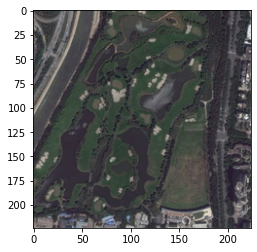

In [22]:
pic = test_paths[0]
img_features = test_img_features[0]
x = plt.imread(pic)
plt.imshow(x)
plt.show()

In [23]:
print("Human-annotated Caption:\n", test_descriptions[0])
human_annotated_caption = [caption.split() for caption in test_descriptions[0]]
human_annotated_caption

Human-annotated Caption:
 ['the lake is surrounded by many thick trees .', 'the resident areas besides the dark green trees .', 'a park with many green trees and several ponds is between a river and some buildings .', 'a park with many green trees and several ponds is between a river and some buildings .', 'the lake is surrounded by many thick trees .']


[['the', 'lake', 'is', 'surrounded', 'by', 'many', 'thick', 'trees', '.'],
 ['the', 'resident', 'areas', 'besides', 'the', 'dark', 'green', 'trees', '.'],
 ['a',
  'park',
  'with',
  'many',
  'green',
  'trees',
  'and',
  'several',
  'ponds',
  'is',
  'between',
  'a',
  'river',
  'and',
  'some',
  'buildings',
  '.'],
 ['a',
  'park',
  'with',
  'many',
  'green',
  'trees',
  'and',
  'several',
  'ponds',
  'is',
  'between',
  'a',
  'river',
  'and',
  'some',
  'buildings',
  '.'],
 ['the', 'lake', 'is', 'surrounded', 'by', 'many', 'thick', 'trees', '.']]

In [24]:
  generated = generateCaption(img_features)
  print("Generated Caption:\n", generated)

Generated Caption:
 many pieces of green plants are in two sides of a river with branches and a bridge over it .


In [25]:
generated.split()

['many',
 'pieces',
 'of',
 'green',
 'plants',
 'are',
 'in',
 'two',
 'sides',
 'of',
 'a',
 'river',
 'with',
 'branches',
 'and',
 'a',
 'bridge',
 'over',
 'it',
 '.']

### 1. BLEU score

**Bilingual Evaluation Understudy Score**

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.


**Cumulative N-Gram Scores**

Cumulative scores refer to the calculation of individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.

The cumulative and individual 1-gram BLEU use the same weights, e.g. (1, 0, 0, 0). The 2-gram weights assign a 50% to each of 1-gram and 2-gram and the 3-gram weights are 33% for each of the 1, 2 and 3-gram scores.

By default, the sentence_bleu() and corpus_bleu() scores calculate the cumulative 4-gram BLEU score, also called BLEU-4.

The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores. 

For more information see [here](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/)

In [26]:
# cummulative bleu score

from nltk.translate.bleu_score import sentence_bleu

b1 = sentence_bleu(human_annotated_caption, generated.split(), weights=(1, 0, 0, 0))
b2 = sentence_bleu(human_annotated_caption, generated.split(), weights=(0.5, 0.5, 0, 0))
b3 = sentence_bleu(human_annotated_caption, generated.split(), weights=(0.33, 0.33, 0.33, 0))
b4 = sentence_bleu(human_annotated_caption, generated.split(), weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU-1 score: %f' % b1)
print('BLEU-2 score: %f' % b2)
print('BLEU-3 score: %f' % b3)
print('BLEU-4 score: %f' % b4)

BLEU-1 score: 0.400000
BLEU-2 score: 0.145095
BLEU-3 score: 0.000000
BLEU-4 score: 0.000000


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


### 2. Rouge-L

ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation. It is essentially of a set of metrics for evaluating automatic summarization of texts as well as machine translation. It works by comparing an automatically produced summary or translation against a set of reference summaries (typically human- produced)

For more information, see [here](http://www.ccs.neu.edu/home/vip/teach/DMcourse/5_topicmodel_summ/notes_slides/What-is-ROUGE.pdf)

In [27]:
!pip install rouge-score

In [28]:
human_annotated_caption_sum = " \n ".join(test_descriptions[0])
human_annotated_caption_sum

'the lake is surrounded by many thick trees . \n the resident areas besides the dark green trees . \n a park with many green trees and several ponds is between a river and some buildings . \n a park with many green trees and several ponds is between a river and some buildings . \n the lake is surrounded by many thick trees .'

In [29]:
# the package can be found here: https://github.com/google-research/google-research/tree/master/rouge
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeLsum'], use_stemmer=True)
scores = scorer.score(human_annotated_caption_sum,
                      generated)
print(scores)
rouge_l_f1 = scores['rougeLsum'][2]
print("Rouge-L score is ", rouge_l_f1)

{'rougeLsum': Score(precision=0.3157894736842105, recall=0.10714285714285714, fmeasure=0.16)}
Rouge-L score is  0.16


In [0]:
rouge_l_f1 = scores['rougeLsum'][2]

### 3. METEOR

METEOR (Metric for Evaluation of Translation with Explicit ORdering) is a metric for the evaluation of machine translation output. The metric is based on the harmonic mean of unigram precision and recall, with recall weighted higher than precision. It also has several features that are not found in other metrics, such as stemming and synonymy matching, along with the standard exact word matching. The metric was designed to fix some of the problems found in the more popular BLEU metric, and also produce good correlation with human judgement at the sentence or segment level

for more information, see [here](https://en.wikipedia.org/wiki/METEOR)

In [0]:
import nltk
### having trouble import the meteor score from nltk

In [40]:
!pip install nltk==3.5

     |████████████████████████████████| 1.4MB 2.8MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434674 sha256=beaad99aa864ce207582d029bd56c6d3a66da16ec492f2f59394bfa37f8c710c
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [37]:
import nltk
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
  
meteor = meteor_score(test_descriptions[0], generated)
meteor

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0.2312138728323699

### 4. CIDEr

In [0]:
# it seems like CideR is computed using all the training images

# python repo : https://github.com/vrama91/cider

# paper : https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Vedantam_CIDEr_Consensus-Based_Image_2015_CVPR_paper.pdf

## 5. universal-sentence-encoder

Based on Shun's recommendation, see [here](https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3)

In [0]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

In [39]:
!pip install tensorflow_text

     |████████████████████████████████| 3.0MB 2.8MB/s 


In [0]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [0]:
# Compute embeddings.
similarity_list = []
hyp_result = embed(generated)

# Compute similarity matrix. Higher score indicates greater similarity.
for caption in test_descriptions[0]:
  ref_result = embed(caption)
  similarity_matrix_it = np.inner(ref_result, hyp_result)
  similarity_list.append(similarity_matrix_it)

In [43]:
avg_similarity = (sum(similarity_list)/len(similarity_list))[0][0]
avg_similarity

0.47760648

In [44]:
### 6. Summary metric
results = pd.DataFrame({"bleu-1": b1,
              "bleu-2": b2,
              "bleu-3": b3,
              "bleu-4": b4,
              "rouge-l": rouge_l_f1,
              "meteor": meteor,
              "CIDEr": "NA",
              "Universal-sentence-encoder similarity": avg_similarity}, index = [pic])

results

,bleu-1,bleu-2,bleu-3,bleu-4,rouge-l,meteor,CIDEr,Universal-sentence-encoder similarity
/content/drive/My Drive/mda/rsicd/park_3.jpg,0.4,0.145095,8.342856e-103,5.681968e-155,0.16,0.231214,NA,0.477606
